## Global PCA Removal

#### Before doing PCA run the 'Trefide for SAN' jupyter notebook

In [ ]:
!pip install tifffile
!pip install numpy
!pip install matplotlib

In [2]:
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import os

In [3]:
# Increase the embed limit if needed (in MB)
import matplotlib as mpl
mpl.rcParams['animation.embed_limit'] = 250

In [4]:
## Load & Normalize Real TIFF Data

tiff_file = './results/SAN_trefide.tif'
data = tiff.imread(tiff_file)  # shape: (T_total, H, W)

# Global normalization to [0,1]
global_min, global_max = data.min(), data.max()
norm_data = (data - global_min) / (global_max - global_min)

## Frame Selection Flag

process_all  = True    # set True to use all frames, False to limit
num_frames   = 100     # used only if process_all is False

# Pick the data to process
if process_all:
    dFF = norm_data            # all frames
else:
    dFF = norm_data[:num_frames]  # first num_frames


## Number of PCs to Remove

num_components = 1  # change to remove a different # of PCs

## PCA Removal Function

def remove_global_pca(movie, n_components):
    """
    Remove the first n_components via PCA (SVD) from a 3D movie.
    movie: 3D array (T, H, W)
    n_components: number of top PCs to remove
    Returns residual movie of same shape.
    """
    T_, H_, W_ = movie.shape
    X = movie.reshape(T_, -1)            # (T) x (H*W)
    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    mode = (U[:, :n_components] * S[:n_components]) @ Vt[:n_components, :]
    resid = X - mode
    return resid.reshape(T_, H_, W_)

## Compute Residual Movie

residual = remove_global_pca(dFF, n_components=num_components)

In [5]:
# Export the normalized ΔF/F and PCA‐residual stacks to multi‐page TIFFs

# Define output filenames
base_name = os.path.splitext(os.path.basename(tiff_file))[0]
residual_outfile = f'{base_name}_afterPCA.tif'

# Clamp negatives to zero, then convert to float32
residual_save = np.clip(residual, 0, None).astype(np.float32)

# Write each as a multipage TIFF
tiff.imwrite(residual_outfile, residual_save, photometric='minisblack')

print(f"Saved PCA‐residual stack to: {residual_outfile}")

Saved PCA‐residual stack to: SAN_trefide_afterPCA.tif


Showing middle slice (frame 863) out of 1726 total frames.


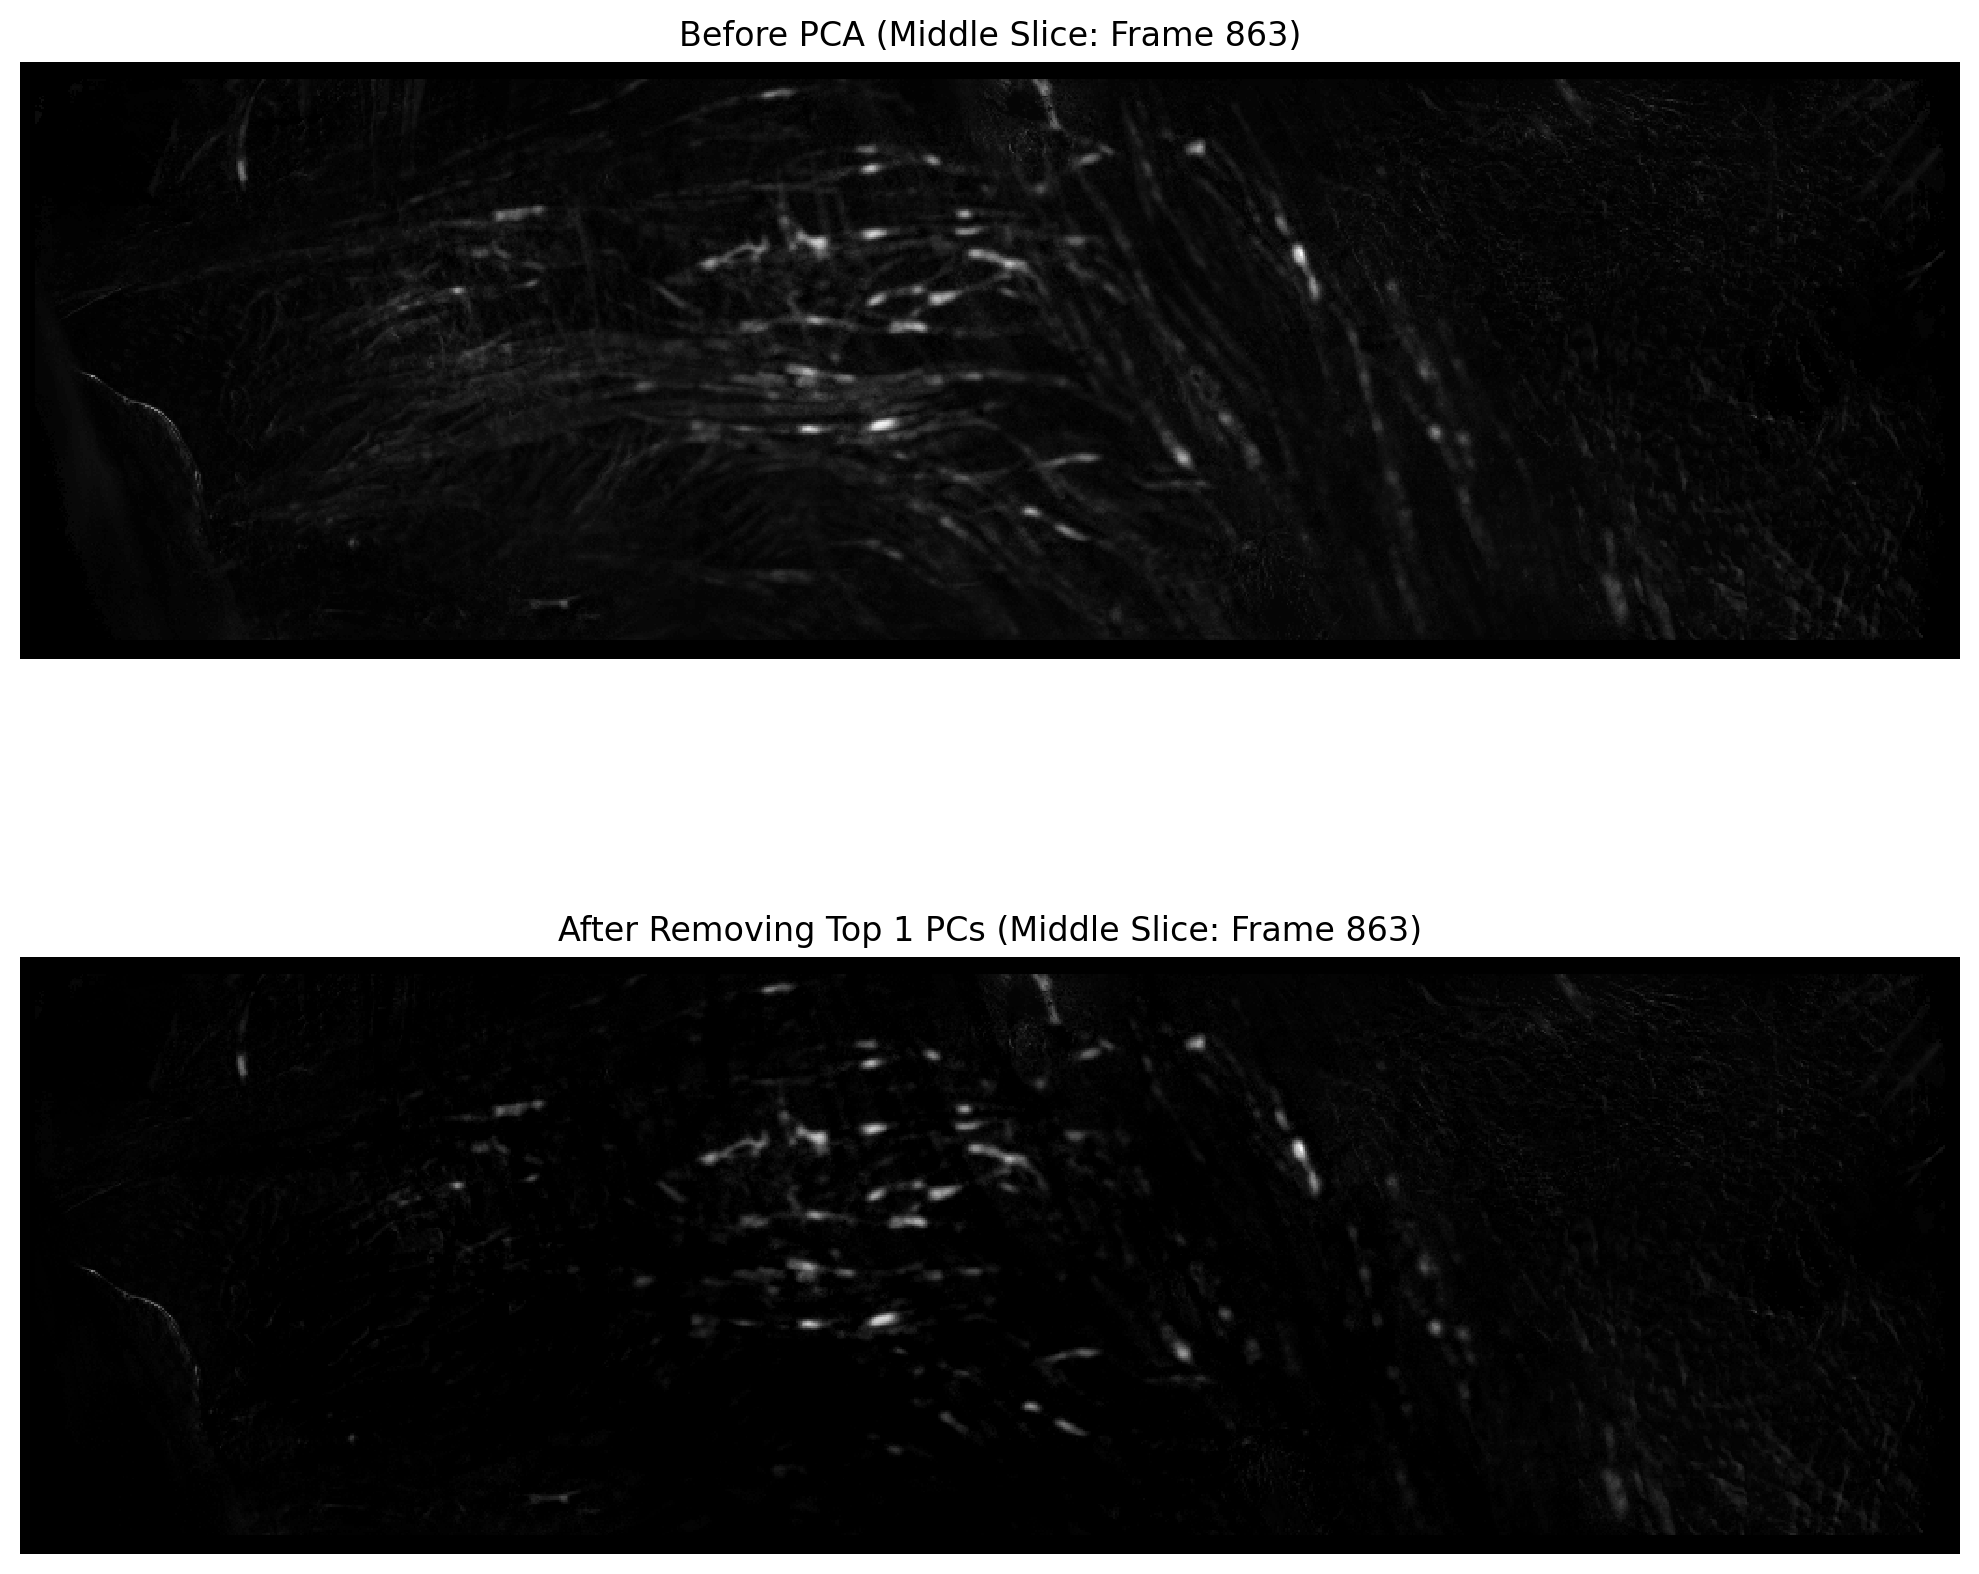

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# The input arrays have shape (T, H, W)
T_total, H, W = dFF.shape

# Find the index of the middle frame
middle_frame_idx = T_total // 2

# Extract the middle slice (a 2D array) from both datasets
dFF_middle_slice = dFF[middle_frame_idx, :, :]
residual_middle_slice = residual_save[middle_frame_idx, :, :]
print(f"Showing middle slice (frame {middle_frame_idx}) out of {T_total} total frames.")


# Change to vertical layout (2 rows, 1 column) - matching the movie code's aspect ratio
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), dpi=200)

# Top Plot: Before PCA
ax1.set_title(f'Before PCA (Middle Slice: Frame {middle_frame_idx})')
ax1.axis('off')
ax1.imshow(
    dFF_middle_slice,
    cmap='gray',
    interpolation='nearest'
)
# Bottom Plot: After PCA
ax2.set_title(f'After Removing Top {num_components} PCs (Middle Slice: Frame {middle_frame_idx})')
ax2.axis('off')
ax2.imshow(
    residual_middle_slice,
    cmap='gray',
    interpolation='nearest'
)
# Use tight_layout to automatically center and adjust spacing
plt.tight_layout()
# Show the plots
plt.show()

In [ ]:
# Movie visualization

# ▶︎ Frame selection flag
show_all_frames = False  # Set to True to show all frames, False to limit
num_frames_to_show = 100  # Number of frames to show when show_all_frames is False

# Use the already processed data with negatives clamped
# dFF_save and residual_save already have negatives set to 0

# Get dimensions and determine frames to use
T = dFF.shape[0]
if show_all_frames:
    frames_to_use = T
    dFF_to_show = dFF_save
    residual_to_show = residual_save
else:
    frames_to_use = min(num_frames_to_show, T)
    dFF_to_show = dFF[:frames_to_use]
    residual_to_show = residual_save[:frames_to_use]

print(f"Showing {frames_to_use} out of {T} total frames")

# Calculate min/max for consistent scaling (min is now 0 due to clipping)
orig_min, orig_max = 0, dFF_to_show.max()
res_min,  res_max  = 0, residual_to_show.max()

# Change to vertical layout (2 rows, 1 column)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))  # Adjusted figure size for vertical layout

ax1.set_title('Before PCA (negatives clipped)')
ax2.set_title(f'After Removing Top {num_components} PCs (negatives clipped)')
ax1.axis('off')
ax2.axis('off')

im1 = ax1.imshow(dFF_to_show[0],     cmap='gray', vmin=orig_min, vmax=orig_max, animated=True)
im2 = ax2.imshow(residual_to_show[0], cmap='gray', vmin=res_min,  vmax=res_max,  animated=True)

def update(frame):
    im1.set_array(dFF_to_show[frame])
    im2.set_array(residual_to_show[frame])
    return im1, im2

anim = FuncAnimation(fig, update, frames=frames_to_use, interval=100, blit=True)
plt.close(fig)

# Display inline
HTML(anim.to_jshtml())

## LCO Heavy Tail Threshold 

#### After PCA we look for LCOs in the heavy tail of the distribution of all pixel intensities at all time points

In [ ]:
!pip install scipy
!pip install pandas

In [14]:
import numpy as np
import pandas as pd
from scipy.stats import genpareto
import matplotlib.pyplot as plt
import tifffile as tiff
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

Starting GPD scan over 100 thresholds
Total positive pixels: 274,578,043

[10/100] threshold = 0.0125
[20/100] threshold = 0.0142
[30/100] threshold = 0.0167
[40/100] threshold = 0.0193
[50/100] threshold = 0.0227
[60/100] threshold = 0.0273
[70/100] threshold = 0.0340
[80/100] threshold = 0.0445
[90/100] threshold = 0.0659
[100/100] threshold = 0.1716

GPD scan complete.



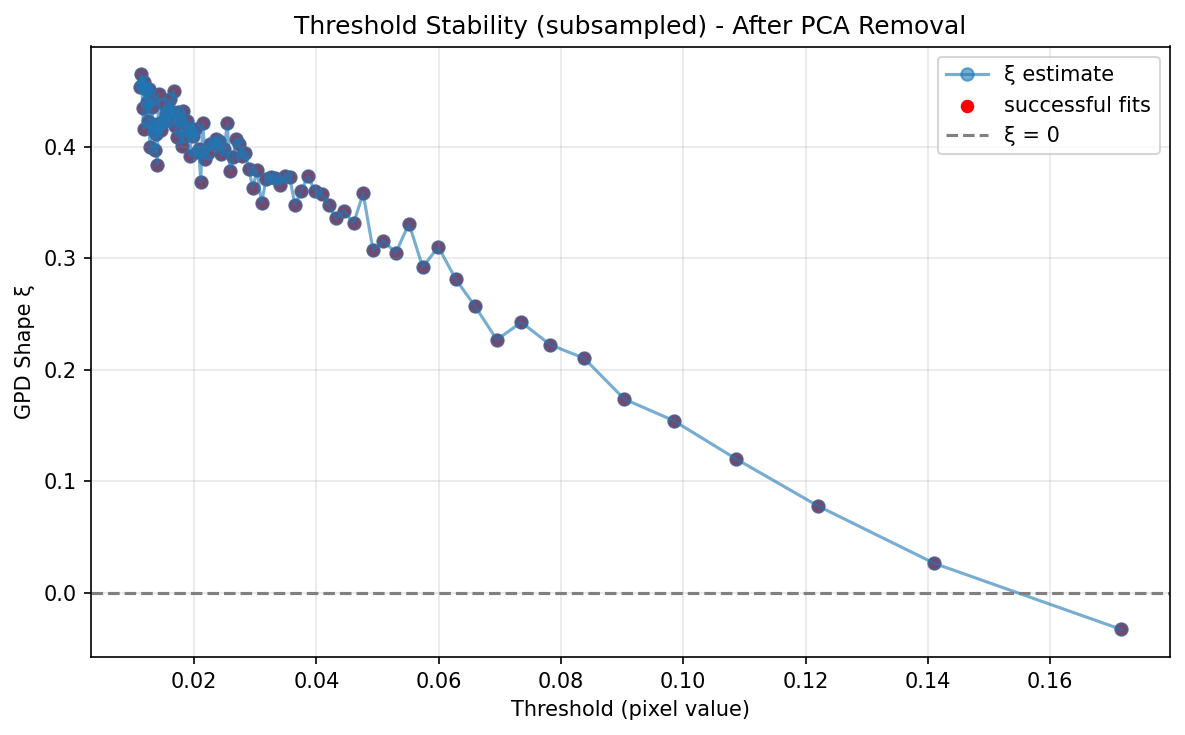

In [15]:
# Residual_save shape is (T, Y, X) where T is time frames

# Flatten and filter out zeros and negatives
pixels = residual_save.ravel()
pos_pixels = pixels[pixels > 0]   # keep only values > 0

#  Prepare data 
arr = np.sort(pos_pixels)
N = arr.size

# Choose set of thresholds via quantiles
num_steps = 100
qs = np.linspace(0.50, 0.99, num_steps)       # 50th→99th percentile
thresholds = np.quantile(arr, qs)

print(f"Starting GPD scan over {len(thresholds)} thresholds")
print(f"Total positive pixels: {N:,}\n")

# parameters for speed
min_points   = 50      # skip if fewer exceedances
max_fit_pts  = 10_000  # down-sample to at most this many points

# prepare lists to collect results
shapes     = []
scales     = []
n_exceed   = []
ok_fit     = []

# Scan thresholds in a simple loop
for i, thr in enumerate(thresholds, start=1):
    # report progress every 10 steps (or on last)
    if i % 10 == 0 or i == len(thresholds):
        print(f"[{i}/{len(thresholds)}] threshold = {thr:.4f}")

    # find how many values exceed thr, using binary search
    idx = np.searchsorted(arr, thr, side='right')
    total_exc = N - idx
    
    if total_exc < min_points:
        shapes.append(np.nan)
        scales.append(np.nan)
        n_exceed.append(total_exc)
        ok_fit.append(False)
        continue
    
    # extract exceedances and subtract threshold
    exc = arr[idx:] - thr
    
    # down-sample if still too large
    if exc.size > max_fit_pts:
        choice = np.random.choice(exc.size, size=max_fit_pts, replace=False)
        exc = exc[choice]
        total_exc = exc.size
    
    # fit GPD to the exceedances (fix loc=0)
    try:
        c, loc, scale = genpareto.fit(exc, floc=0)
        shapes.append(c)
        scales.append(scale)
        n_exceed.append(total_exc)
        ok_fit.append(True)
    except Exception as e:
        shapes.append(np.nan)
        scales.append(np.nan)
        n_exceed.append(total_exc)
        ok_fit.append(False)
        print(f"    Fit failed at threshold {thr:.4f}: {e}")

# Pack into DataFrame
df = pd.DataFrame({
    'threshold': thresholds,
    'shape':      shapes,
    'scale':      scales,
    'n_exceed':   n_exceed,
    'ok_fit':     ok_fit
})

print("\nGPD scan complete.\n")

# Plot ξ vs. threshold
plt.figure(figsize=(8, 5), dpi=150)
plt.plot(df['threshold'], df['shape'], 'o-', alpha=0.6, label='ξ estimate')
ok = df['ok_fit']
plt.scatter(df.loc[ok, 'threshold'], df.loc[ok, 'shape'],
            c='red', s=30, label='successful fits')
plt.axhline(0, color='gray', linestyle='--', label='ξ = 0')
plt.xlabel('Threshold (pixel value)')
plt.ylabel('GPD Shape ξ')
plt.title('Threshold Stability (subsampled) - After PCA Removal')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [16]:
# Find where ξ actually flips from + to – and interpolate to ξ=0
# only consider the rows where the fit succeeded
df2 = df[df['ok_fit']]

# find the first index where we go from shape>0 to shape<0
mask = (df2['shape'].shift(1) > 0) & (df2['shape'] < 0)

if not mask.any():
    print("ξ never flips sign in the scanned thresholds.")
else:
    # idx_hi is the first row where shape<0
    idx_hi = mask.idxmax()
    idx_lo = idx_hi - 1

    thr_lo, xi_lo, ne_lo = df2.loc[idx_lo, ['threshold','shape','n_exceed']]
    thr_hi, xi_hi, ne_hi = df2.loc[idx_hi, ['threshold','shape','n_exceed']]

    # linear interpolation for thr such that ξ=0
    thr_zero = thr_lo - xi_lo * (thr_hi - thr_lo) / (xi_hi - xi_lo)

    print("ξ crosses zero between:")
    print(f"   lo: thr = {thr_lo:.4f}, ξ = {xi_lo:.4f}, n_exceed = {ne_lo}")
    print(f"   hi: thr = {thr_hi:.4f}, ξ = {xi_hi:.4f}, n_exceed = {ne_hi}")
    print(f"→ interpolated ξ=0 at thr ≃ {thr_zero:.4f}")

ξ crosses zero between:
   lo: thr = 0.1411, ξ = 0.0264, n_exceed = 10000
   hi: thr = 0.1716, ξ = -0.0327, n_exceed = 10000
→ interpolated ξ=0 at thr ≃ 0.1547


In [17]:
# Clip at the zero-crossing 
# everything below thr_zero becomes thr_zero
clipped = np.maximum(residual_save, thr_zero)

# Shift so minimum is 0
shifted = clipped - thr_zero

# Normalize to [0, 255]
# find the maximum possible value in the shifted stack
max_val = shifted.max()
if max_val == 0:
    raise ValueError("All values are zero after clipping — check your threshold!")
normalized = (shifted / max_val) * 255.0

# Convert to uint8 and re-export
out = normalized.astype(np.uint8)

# Since residual_save is (T, Y, X), set axes accordingly
axes = 'TYX'

base_name = os.path.splitext(os.path.basename(tiff_file))[0]
out_name = f'{base_name}_afterPCA_afterHeayTailsThresh.tif'

tiff.imwrite(
    out_name,
    out,
    photometric='minisblack',
    metadata={'axes': axes}
)
print(f"Wrote clipped + normalized volume to {out_name}")

Wrote clipped + normalized volume to SAN_trefide_afterPCA_afterHeayTailsThresh.tif


Showing middle slice (frame 863) out of 1726 total frames.


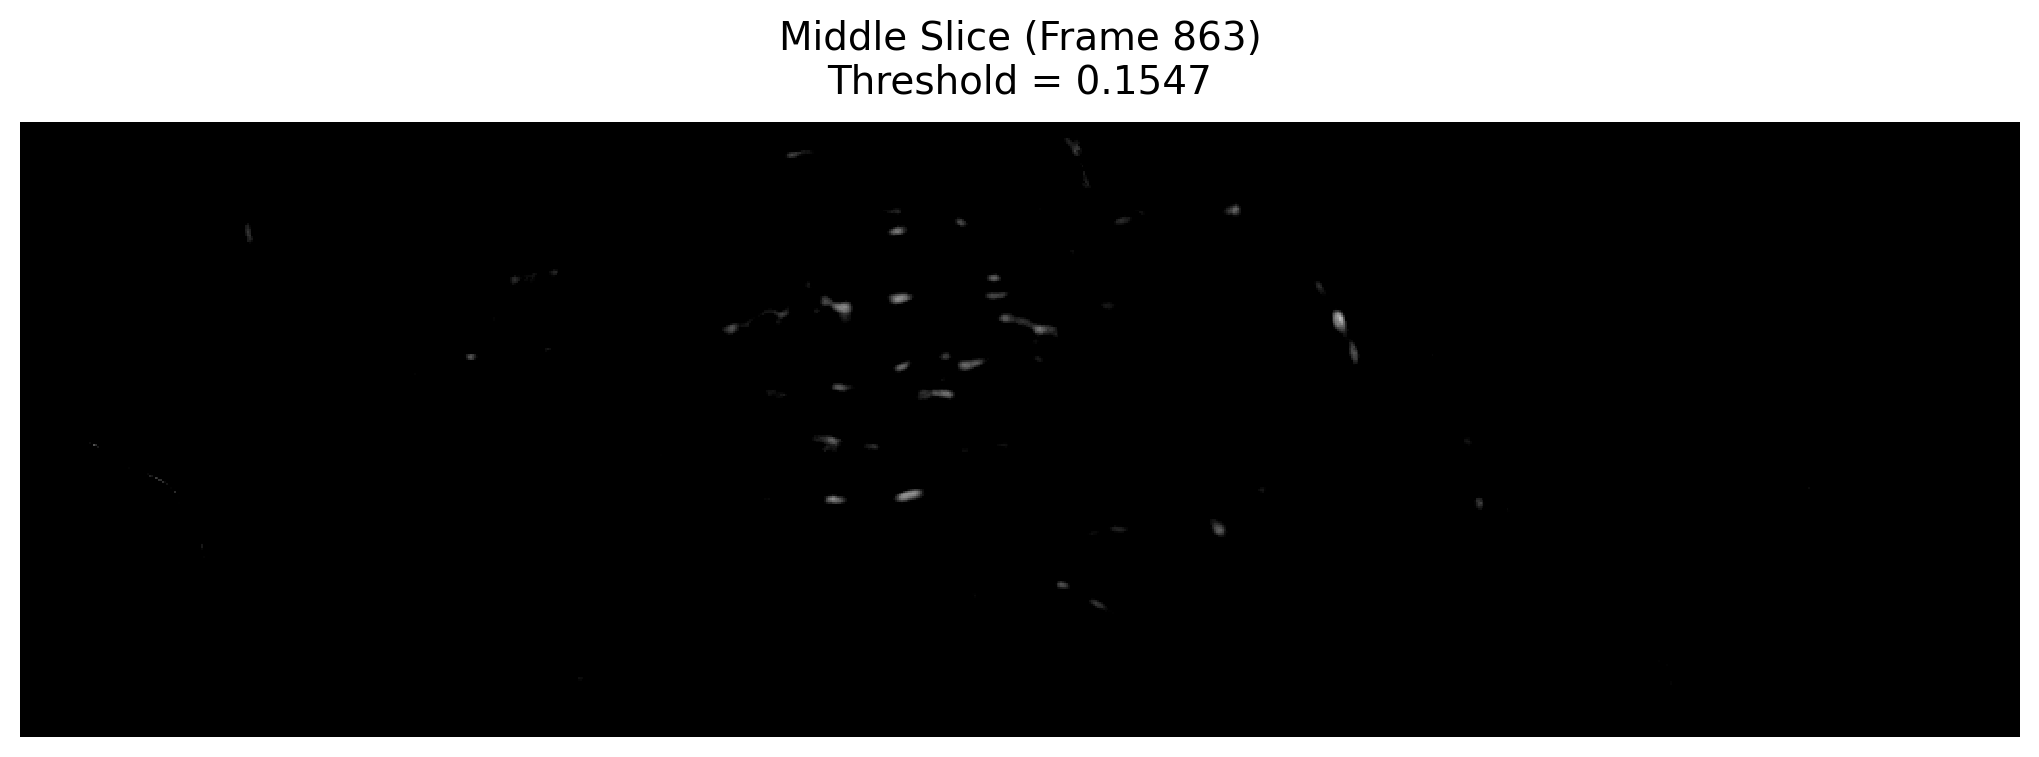

In [18]:
# The input array 'out' has shape (T, H, W)
T_total, H, W = out.shape

# Find the index of the middle frame
middle_frame_idx = T_total // 2

# Extract the middle slice, which is a 2D array of shape (H, W)
# We slice along the first axis (T)
middle_slice = out[middle_frame_idx, :, :]

print(f"Showing middle slice (frame {middle_frame_idx}) out of {T_total} total frames.")

# Maintain aspect ratio and remove margins
fig_w = 10
fig_h = fig_w * (H / W)
fig, ax = plt.subplots(figsize=(fig_w, fig_h), dpi=200)
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
ax.axis('off')

# Display the static image of the middle slice
ax.imshow(
    middle_slice,
    cmap='gray',
    vmin=0,         # Data is uint8 (0-255)
    vmax=255,
    interpolation='nearest'
)

ax.set_title(
    f'Middle Slice (Frame {middle_frame_idx})\nThreshold = {thr_zero:.4f}',
    fontsize=14,
    pad=10
)

plt.show()

In [ ]:
# Movie visualization

# ▶︎ Frame selection flag
show_all_frames = False  # Set to True to show all frames, False to limit
num_frames_to_show = 100  # Number of frames to show when show_all_frames is False

# Get dimensions and determine frames to use
T, H, W = out.shape
if show_all_frames:
    frames_to_use = T
    data_to_show = out
else:
    frames_to_use = min(num_frames_to_show, T)
    data_to_show = out[:frames_to_use]

print(f"Showing {frames_to_use} out of {T} total frames")

# Figure setup
fig_w = 10
fig_h = fig_w * (H / W)
fig, ax = plt.subplots(figsize=(fig_w, fig_h))
ax.axis('off')
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)

# Initial draw
im = ax.imshow(
    data_to_show[0],
    cmap='gray', 
    vmin=0,
    vmax=255,
    interpolation='nearest',
    animated=True
)

ax.set_title(f'Heavy Tail Thresholded Data (threshold = {thr_zero:.4f})', 
             fontsize=14, pad=10)

# Update function
def update(i):
    im.set_array(data_to_show[i])
    return [im]

# Animate
anim = FuncAnimation(
    fig, update, frames=frames_to_use, interval=100, blit=True
)
plt.close(fig)

# Display the animation
HTML(anim.to_jshtml())